In [37]:
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
numpyro.enable_x64()    
# posterior samples
import numpy as np
from scipy.stats import gaussian_kde

import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import jax.random as random
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
from datetime import datetime
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.lines import Line2D

import seaborn as sns
import warnings
warnings.simplefilter('ignore')
def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

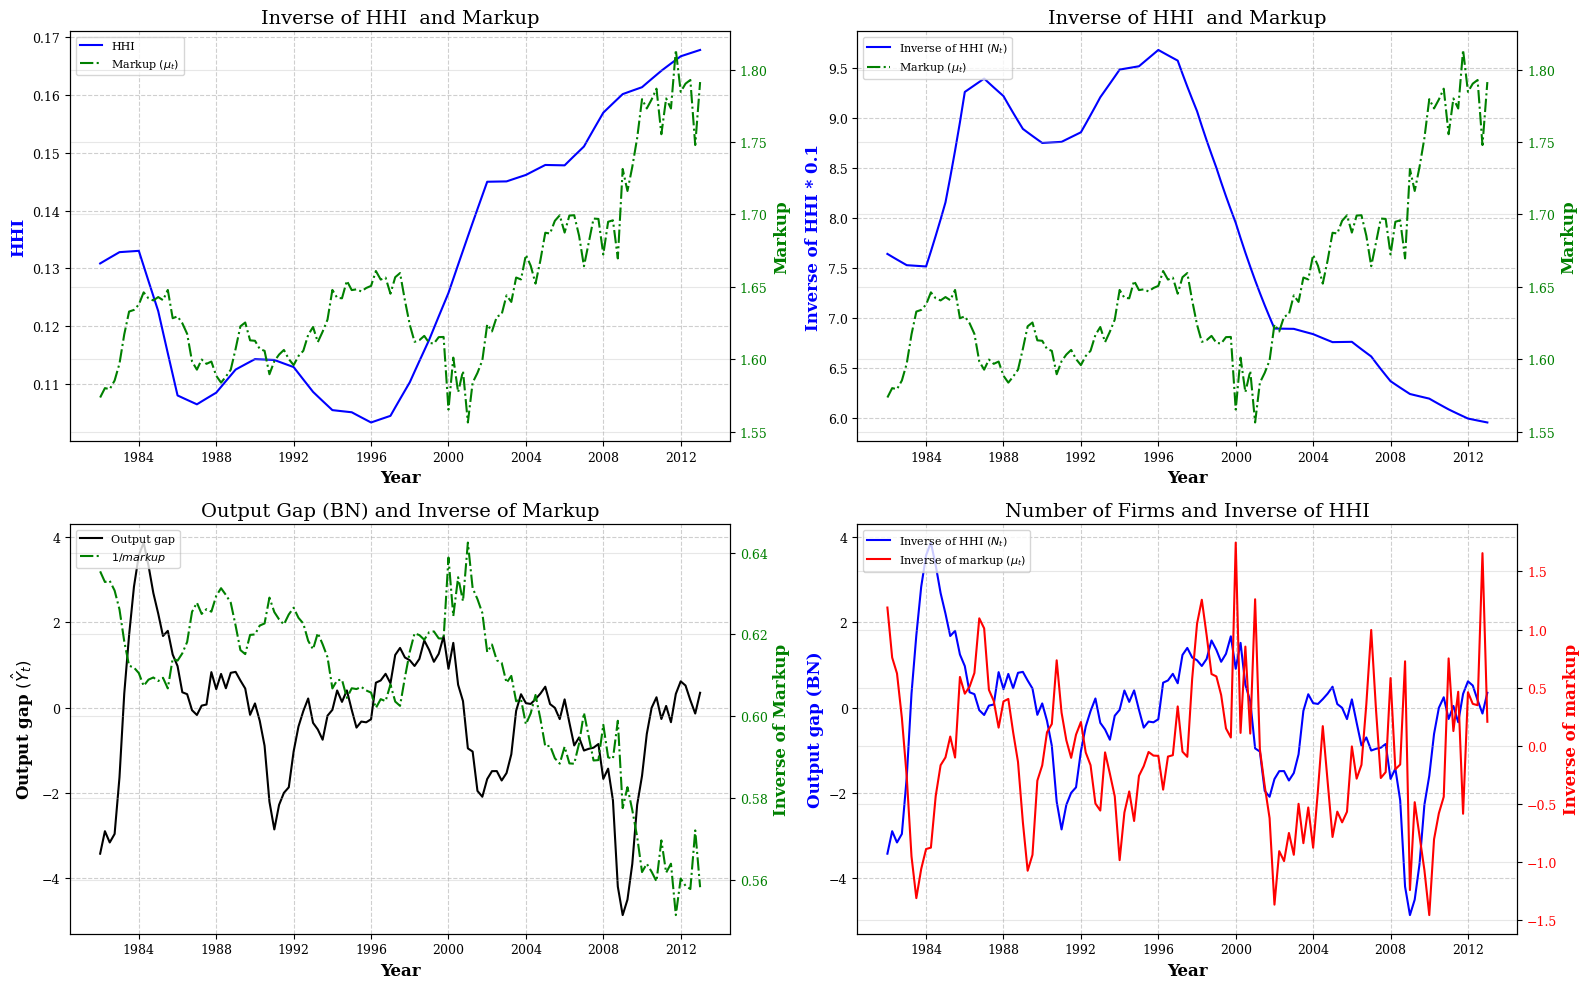

In [38]:
# Data
# cpi data
data_cpi = pd.read_csv("../data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change(4) * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()
data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])

# Number of Firm data
data_HHI_annual = pd.read_csv("../data/hhi_from_Gustavo_2019.csv")
data_HHI_annual["HHI"] = data_HHI_annual["Value"] * 0.0001
data_HHI_annual['year'] = pd.to_datetime(data_HHI_annual['Year'], format='%Y') + pd.offsets.YearBegin(0)
data_HHI_annual = data_HHI_annual.set_index('year')
data_HHI = data_HHI_annual.resample('QS').asfreq()
data_HHI['HHI'] = data_HHI['HHI'].interpolate(method='linear')
data_HHI = data_HHI.reset_index()
data_HHI['DATE'] = pd.to_datetime(data_HHI['year'])
data_HHI = data_HHI[["DATE", "HHI"]]
data_HHI["N"] = 1/data_HHI["HHI"]

# Markup data
data_markup = pd.read_excel("../data/nekarda_ramey_markups.xlsx")
data_markup['DATE'] = pd.to_datetime(data_markup['qdate'], format='%Y-%m-%d')
data_markup['markup'] = data_markup['mu_bus']
data_markup = data_markup[['DATE', 'markup']].dropna()

# De-trended Markup data
data_markup_BN = pd.read_csv("../data/BN_markup_inv.csv")
data_markup_BN['markup_BN_inv'] = data_markup_BN["cycle"] 
data_markup_BN['DATE'] = data_markup_BN["date"]
data_markup_BN = data_markup_BN[["DATE","markup_BN_inv"]].dropna()
data_markup_BN['DATE'] = pd.to_datetime(data_markup_BN['DATE'])

# unemployment gap
# NROU
data_nairu = pd.read_csv("../data/NROU.csv")
data_nairu["DATE"] = pd.to_datetime(data_nairu["observation_date"])
# unemployment
data_unemp = pd.read_csv("../data/UNRATENSA.csv")
data_unemp["DATE"] = pd.to_datetime(data_unemp["observation_date"])
data_unempgap = pd.merge(data_nairu, data_unemp, on="DATE", how="outer")
data_unempgap['unemp_gap'] = data_unempgap['NROU'] - data_unempgap['UNRATENSA']
data_unempgap = data_unempgap.dropna()
data_unempgap = data_unempgap[["DATE", "unemp_gap"]]

# output gap data
data_output = pd.read_csv("../data/BN_filter_GDPC1_quaterly.csv")
data_output['output_BN'] = data_output['GDPC1_transformed_series']
data_output['output_gap_BN'] = data_output["cycle"]
data_output['output'] = np.log(data_output["GDPC1_original_series"] * 0.01)
data_output['DATE'] = data_output["date"]
data_output["output_trend_BN"] = data_output["output_BN"] - data_output["output_gap_BN"]
data_output = data_output[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]].dropna()
data_output['DATE'] = pd.to_datetime(data_output['DATE'])

# inflation expectation data
data_Epi = pd.read_csv("../data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])

# Merge all dataframes
data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_output, on="DATE", how="outer")
data = pd.merge(data, data_HHI, on="DATE", how="outer")
data = pd.merge(data, data_markup, on="DATE", how="outer")
data = pd.merge(data, data_markup_BN, on="DATE", how="outer")
data = pd.merge(data, data_unempgap, on="DATE", how="outer")
data["pi_prev"] = data["pi"].shift(1)
data["output_gap_prev"] = data["output_gap_BN"].shift(1)
data["markup_prev"] = data["markup"].shift(1)
data['N_prev'] = data['N'].shift(1)
data = data.dropna()
# for MCMC
pi = jnp.array(data['pi'],dtype=jnp.float64)
pi_prev = jnp.array(data['pi_prev'],dtype=jnp.float64)
pi_expect = jnp.array(data['Epi'],dtype=jnp.float64)
N = jnp.array(data['N'],dtype=jnp.float64)
Y = jnp.array(data['output'],dtype=jnp.float64)
x_markup = jnp.array(1/data['markup'],dtype=jnp.float64)
x_output_gap = jnp.array(data['output_gap_BN'],dtype=jnp.float64)
x_markup_bn = jnp.array(data['markup_BN_inv'],dtype=jnp.float64)
x_unempgap = jnp.array(data['unemp_gap'],dtype=jnp.float64)

# --- 2×2 graph ---
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# --- 1. Inflation and Expected Inflation ---
ax1= axs[0, 0]
ax1_left = ax1
ax1_right = ax1_left.twinx()
ax1_left.plot(data["DATE"], data["HHI"], label=r'HHI', color='blue')
ax1_right.plot(data["DATE"], data["markup"], label=r'Markup $(\mu_{t})$', linestyle='-.', color='green')
ax1_left.set_xlabel('Year', fontsize=12, weight='bold')
ax1_left.set_ylabel('HHI', fontsize=12, weight='bold', color = 'blue')
ax1_right.set_ylabel('Markup', fontsize=12, weight='bold', color='green')
ax1_right.tick_params(axis='y', labelcolor='green')
ax1_left.grid(True, linestyle='--', alpha=0.6)
ax1_left.set_title('Inverse of HHI  and Markup', fontsize=14)
lines = ax1_left.get_lines() + ax1_right.get_lines()
labels = [line.get_label() for line in lines]
ax1_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- 2. Number of Firms and Markup ---
ax2 = axs[0, 1]
ax2_left = ax2
ax2_right = ax2_left.twinx()
ax2_left.plot(data["DATE"], data["N"], label=r'Inverse of HHI $(N_{t})$', color='blue')
ax2_right.plot(data["DATE"], data["markup"], label=r'Markup $(\mu_{t})$', linestyle='-.', color='green')
ax2_left.set_xlabel('Year', fontsize=12, weight='bold')
ax2_left.set_ylabel('Inverse of HHI * 0.1', fontsize=12, weight='bold', color = 'blue')
ax2_right.set_ylabel('Markup', fontsize=12, weight='bold', color='green')
ax2_right.tick_params(axis='y', labelcolor='green')
ax2_left.grid(True, linestyle='--', alpha=0.6)
ax2_left.set_title('Inverse of HHI  and Markup', fontsize=14)
lines = ax2_left.get_lines() + ax2_right.get_lines()
labels = [line.get_label() for line in lines]
ax2_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- 3. Output Gap and Inverse Markup ---
ax3 = axs[1, 0]
ax3_left = ax3
ax3_right = ax3_left.twinx()
ax3_left.plot(data["DATE"], data["output_gap_BN"], label='Output gap', color='black')
ax3_right.plot(data["DATE"], 1/data["markup"], label=r'$1/markup$', linestyle='-.', color='green')
ax3_left.set_xlabel('Year', fontsize=12, weight='bold')
ax3_left.set_ylabel(r'Output gap $(\hat{Y}_t)$', fontsize=12, weight='bold')
ax3_right.set_ylabel('Inverse of Markup', fontsize=12, weight='bold', color='green')
ax3_right.tick_params(axis='y', labelcolor='green')
ax3_left.grid(True, linestyle='--', alpha=0.6)
ax3_left.set_title('Output Gap (BN) and Inverse of Markup', fontsize=14)
lines = ax3_left.get_lines() + ax3_right.get_lines()
labels = [line.get_label() for line in lines]
ax3_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- 4. Inverse HHI and markup ---
ax4 = axs[1, 1]
ax4_left = ax4
ax4_right = ax4_left.twinx()
ax4_left.plot(data["DATE"], data["output_gap_BN"], label=r'Inverse of HHI $(N_{t})$', color='blue')
ax4_right.plot(data["DATE"], data["markup_BN_inv"], label=r'Inverse of markup $(\mu_{t})$', color='red')
ax4_left.set_xlabel('Year', fontsize=12, weight='bold')
ax4_left.set_ylabel('Output gap (BN)', fontsize=12, weight='bold', color='blue')
ax4_right.set_ylabel('Inverse of markup', fontsize=12, weight='bold', color='red')
ax4_right.tick_params(axis='y', labelcolor='red')
ax4_left.grid(True, linestyle='--', alpha=0.6)
ax4_left.set_title('Number of Firms and Inverse of HHI', fontsize=14)
lines = ax4_left.get_lines() + ax4_right.get_lines()
labels = [line.get_label() for line in lines]
ax4_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- Layout ---
plt.tight_layout()
plt.show()

In [39]:
def set_prior_distributions():
    priors = {
        # NKPC params
        "alpha"      : dist.Beta(12, 12),
        "kappa"      : dist.Normal(0, 0.1),
        "theta"      : dist.Normal(0, 0.1), 
        "n"          : dist.Normal(0, 0.1), 
        # Sigma
        "sigma_u"    : dist.InverseGamma(0.001, 0.001),  
        "sigma_eps"  : dist.InverseGamma(0.001, 0.001),  
        "sigma_v"    : dist.InverseGamma(0.001, 0.001),  
        "sigma_mu"   : dist.InverseGamma(0.001, 0.001),  
        "sigma_e"    : dist.InverseGamma(0.001, 0.001),  
        "sigma_eta"  : dist.InverseGamma(0.001, 0.001),  
    }
    return priors

In [40]:
# model
def model_0(pi, pi_prev, pi_expect, x):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha", priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    # Sigma
    sigma_v = numpyro.sample("sigma_v", priors["sigma_v"])
    # model
    pi_pred = alpha * pi_prev + (1-alpha) * pi_expect + kappa * x
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi)

def model_1(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))      
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))   # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, .05))    # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .05))    # Nhat init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        t = carry[3]
        # state equation
        # trend 
        Nbar_t = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1 , t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, t], timesteps)


In [41]:
warmup= 1000
samples=9000
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

In [42]:
x = x_markup
# NKPC under CES before financial crisis =================================================
print("NKPC under CES/ markup")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc_0_markup = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_markup.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x)
idata_0_markup = az.from_numpyro(mcmc_0_markup)
posterior_samples = mcmc_0_markup.get_samples()
diverging  = idata_0_markup.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param

x = x_output_gap
# NKPC under CES before financial crisis =================================================
print("NKPC under CES/ output gap")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc_0_output = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_output.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x)
idata_0_output = az.from_numpyro(mcmc_0_output)
posterior_samples = mcmc_0_output.get_samples()
diverging  = idata_0_output.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param

x = x_markup_bn
# NKPC under CES before financial crisis =================================================
print("NKPC under CES/ markup (inverse)")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc_0_markup_bn = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_markup_bn.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x)
idata_0_markup_bn = az.from_numpyro(mcmc_0_markup_bn)
posterior_samples_markup_bn = mcmc_0_markup_bn.get_samples()
diverging  = idata_0_markup_bn.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param

x = x_unempgap
# NKPC under CES before financial crisis =================================================
print("NKPC under CES/unemployment gap")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc_0_unempgap = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc_0_unempgap.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x)
idata_0_unempgap = az.from_numpyro(mcmc_0_unempgap)
posterior_samples_unempgap = mcmc_0_unempgap.get_samples()
diverging  = idata_0_unempgap.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param

NKPC under CES/ markup


sample: 100%|██████████| 10000/10000 [00:03<00:00, 3200.82it/s, 15 steps of size 2.14e-01. acc. prob=0.99]


model 0: divergence ratio = 0.0000%
NKPC under CES/ output gap


sample: 100%|██████████| 10000/10000 [00:03<00:00, 3136.54it/s, 15 steps of size 2.08e-01. acc. prob=0.99]


model 0: divergence ratio = 0.0000%
NKPC under CES/ markup (inverse)


sample: 100%|██████████| 10000/10000 [00:03<00:00, 3214.99it/s, 15 steps of size 2.15e-01. acc. prob=0.99]


model 0: divergence ratio = 0.0000%
NKPC under CES/unemployment gap


sample: 100%|██████████| 10000/10000 [00:03<00:00, 2934.43it/s, 15 steps of size 2.12e-01. acc. prob=0.99]


model 0: divergence ratio = 0.0000%


In [43]:
import os
import numpy as np
import pandas as pd
from scipy.stats import norm, gaussian_kde

# ---- SDDR(BF_01) for kappa with Normal(0,0.01) prior ----
def sddr(idata, mu=0.0, sigma=0.1):
    """BF_01 = posterior_density_at_0 / prior_density_at_0"""
    # posterior draws of kappa
    post = np.asarray(idata.posterior["kappa"]).ravel()
    post = post[np.isfinite(post)]
    if post.size < 10:
        return np.nan  # safety

    # posterior density at 0 (KDE)
    kde = gaussian_kde(post)
    post_at0 = float(kde.evaluate([0.0])[0])

    # prior density at 0
    prior_at0 = norm.pdf(0.0, loc=mu, scale=sigma)

    return post_at0 / max(prior_at0, 1e-300)

# ---- Collect models ----
models = [
    ("CES: Markup",        idata_0_markup),
    ("CES: Output gap",    idata_0_output),
    ("CES: Markup (BN)",   idata_0_markup_bn),
    ("CES: Unemp. gap",    idata_0_unempgap),
]

rows = []
for name, idata in models:
    bf01 = sddr(idata, mu=0.0, sigma=0.1)
    rows.append({"Model": name, "SDDR_BF01_kappa": bf01})

df_sddr = pd.DataFrame(rows)

# ---- Save to Markdown (no extra deps) ----
def df_to_markdown(df: pd.DataFrame) -> str:
    header = "| " + " | ".join(df.columns) + " |"
    separator = "| " + " | ".join([":---" for _ in df.columns]) + " |"
    lines = ["| " + " | ".join(f"{v:.5f}" if isinstance(v,(int,float,np.floating)) and np.isfinite(v) else str(v) for v in row) + " |"
             for row in df.itertuples(index=False, name=None)]
    return "\n".join([header, separator] + lines)

outdir = "../estimated_coef"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, "ces_sddr_hmc.md")

with open(outfile, "w", encoding="utf-8") as f:
    f.write(df_to_markdown(df_sddr))

print("Saved:", outfile)
display(df_sddr)

Saved: ../estimated_coef/ces_sddr_hmc.md


,Model,SDDR_BF01_kappa
0,CES: Markup,1.025870
1,CES: Output gap,1.364261
2,CES: Markup (BN),1.480209
3,CES: Unemp. gap,0.682951


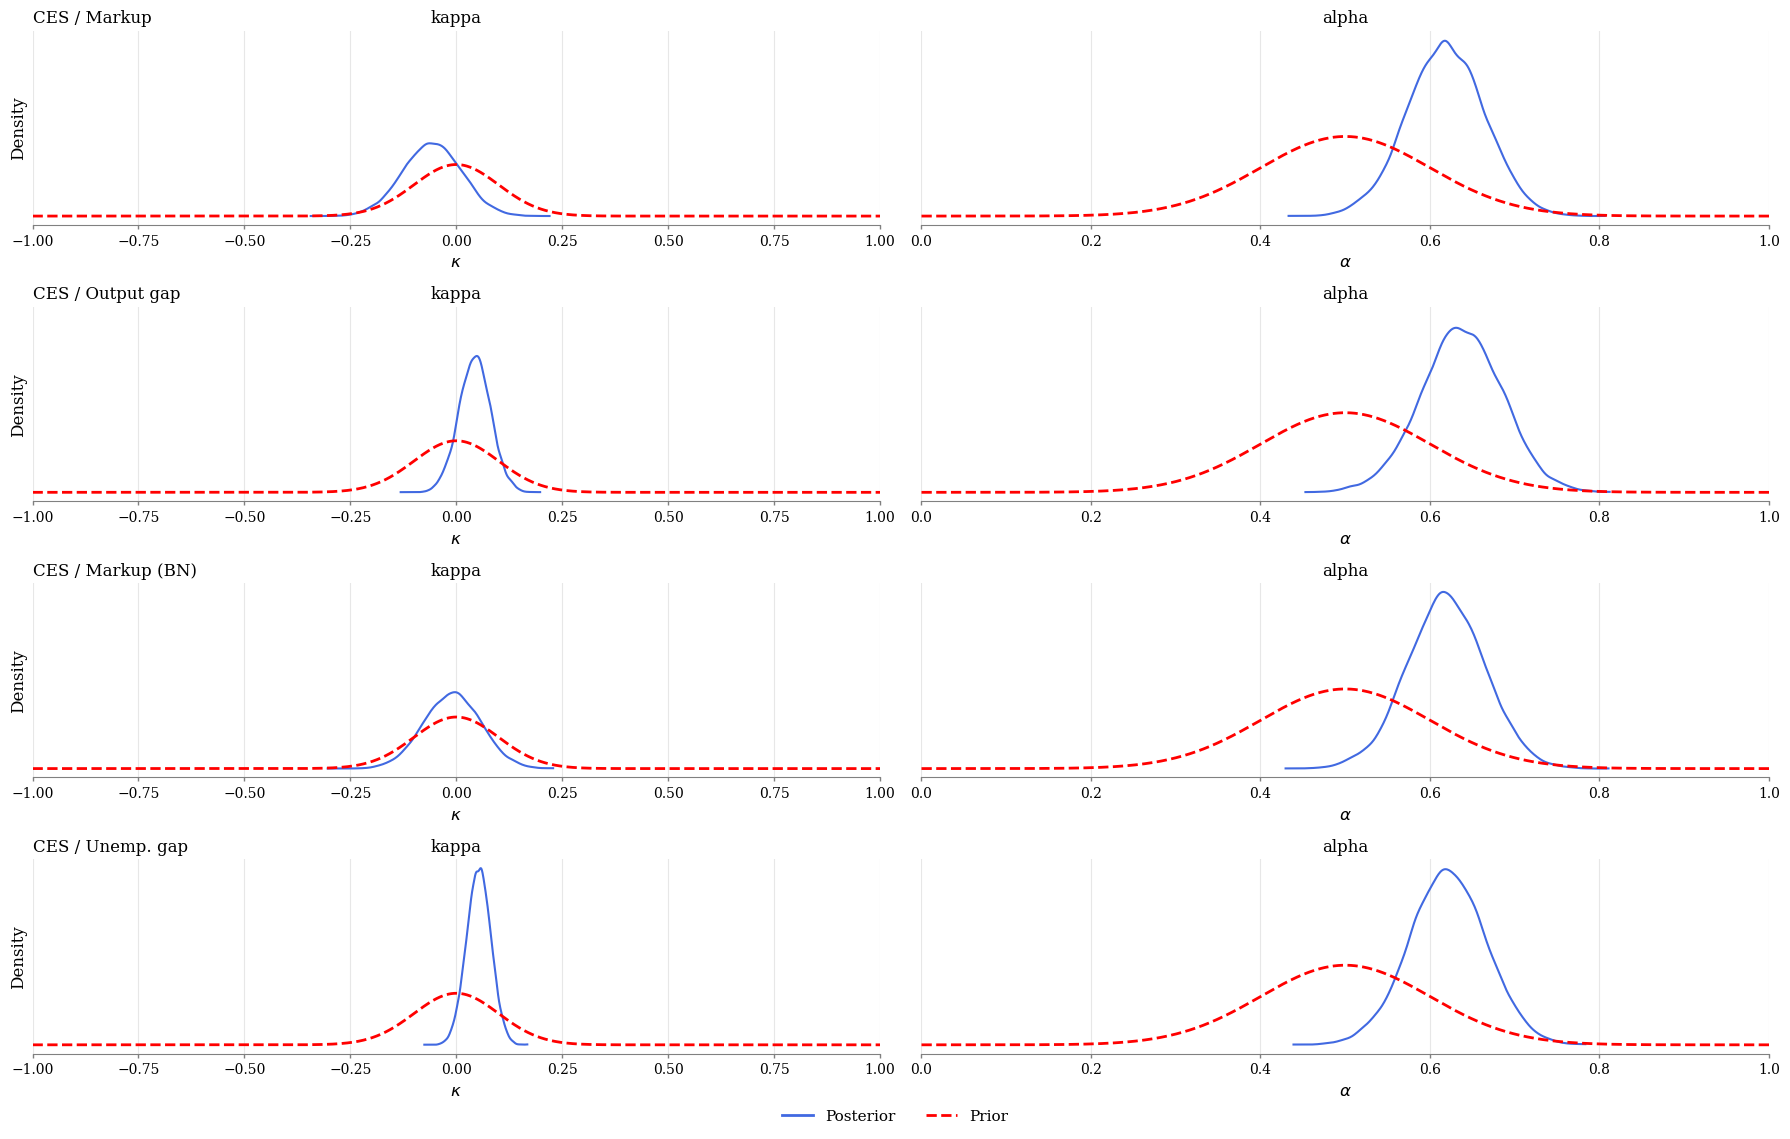

In [47]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import norm

def plot_prior_posterior_grid(idatas, labels, 
                              params=("kappa","alpha"),
                              figsize=(9, 2.8),
                              savepath=None,
                              xlims=None):
    """
    idatas : list of InferenceData
    labels : list of str
    params : tuple of parameter names
    xlims  : dict, optional
        e.g. {"kappa": (-0.05, 0.05), "alpha": (0, 1)}
    """

    assert len(idatas) == len(labels)
    n_rows = len(idatas)
    n_cols = len(params)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(figsize[0]*n_cols, figsize[1]*n_rows),
                             squeeze=False, sharey='col')

    # prior specification 
    priors = {
        "alpha": {"mu": 0.5, "sigma": 0.1},
        "kappa": {"mu": 0.0, "sigma": 0.1},
    }

    for i, (idata, label_row) in enumerate(zip(idatas, labels)):
        for j, param in enumerate(params):
            ax = axes[i, j]

            # posterior
            az.plot_posterior(
                idata,
                var_names=[param],
                point_estimate=None,
                hdi_prob="hide",
                kind="kde",
                color="royalblue",
                ax=ax,
            )

            # prior
            if param in priors:
                mu, sigma = priors[param]["mu"], priors[param]["sigma"]

                # range: use xlims if provided, else ±5σ
                if xlims and param in xlims:
                    xmin, xmax = xlims[param]
                else:
                    xmin, xmax = mu - 5*sigma, mu + 5*sigma

                x = np.linspace(xmin, xmax, 1000)
                y = norm.pdf(x, mu, sigma)
                ax.plot(x, y, "r--", lw=2, label="Prior")

            # labels
            if j == 0:
                ax.set_ylabel("Density", fontsize=12)
                ax.set_title(label_row, fontsize=12, loc="left")
            else:
                ax.set_ylabel("")
            ax.set_xlabel({"kappa": r"$\kappa$", "alpha": r"$\alpha$"}.get(param, param),
                          fontsize=12)
            ax.tick_params(labelsize=10)

            # xlim を固定
            if xlims and param in xlims:
                ax.set_xlim(xlims[param])

    # legend
    legend_handles = [
        Line2D([0], [0], color="royalblue", lw=2, label="Posterior"),
        Line2D([0], [0], color="red", lw=2, ls="--", label="Prior"),
    ]
    fig.legend(handles=legend_handles, fontsize=11,
               loc="lower center", ncol=2, frameon=False,
               bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout()

    if savepath:
        fig.savefig(savepath, bbox_inches="tight", dpi=300)

    return fig
idatas = [
    idata_0_markup,
    idata_0_output,
    idata_0_markup_bn,
    idata_0_unempgap,
]
labels = [
    "CES / Markup",
    "CES / Output gap",
    "CES / Markup (BN)",
    "CES / Unemp. gap",
]

fig = plot_prior_posterior_grid(
    idatas=idatas,
    labels=labels,
    params=("kappa","alpha"),
    savepath="../figure/ces_results_hmc.png",
    xlims={"kappa": (-1, 1), "alpha": (0, 1)}  
)
plt.show()

## HSA: markup

In [49]:
# x = x_markup
# # NKPC under HSA : no shift in slope / before financial crisis ==============================
# print("NKPC under HSA : no shift in slope, before financial crisis")
# kernel = NUTS(model_1, target_accept_prob=0.95)
# mcmc_1_markup = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
# mcmc_1_markup.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, N = N, l=len(pi))
# idata_1_markup = az.from_numpyro(mcmc_1_markup)
# posterior_samples_markup = mcmc_1_markup.get_samples()
# N_bar_samples_markup = posterior_samples_markup["Nbar"]
# N_bar_mean_markup = np.mean(N_bar_samples_markup, axis=0) 
# N_bar_std_markup = np.std(N_bar_samples_markup, axis=0)  
# N_bar_lower_markup = N_bar_mean_markup - 1.97 * N_bar_std_markup
# N_bar_upper_markup = N_bar_mean_markup + 1.97 * N_bar_std_markup
# N_hat_samples_markup = posterior_samples_markup["Nhat"]
# N_hat_mean_markup = np.mean(N_hat_samples_markup, axis=0) 
# N_hat_std_markup = np.std(N_hat_samples_markup, axis=0)  
# N_hat_lower_markup = N_hat_mean_markup - 1.97 * N_hat_std_markup
# N_hat_upper_markup = N_hat_mean_markup + 1.97 * N_hat_std_markup
# diverging  = idata_1_markup.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
# print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

x = x_output_gap
# NKPC under HSA : no shift in slope / before financial crisis ==============================
print("NKPC under HSA : no shift in slope, before financial crisis")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc_1_output = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc_1_output.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, N = N, l=len(pi))
idata_1_output = az.from_numpyro(mcmc_1_output)
posterior_samples_1_output = mcmc_1_output.get_samples()
N_bar_samples_1_output = posterior_samples_1_output["Nbar"]
N_bar_mean_1_output = np.mean(N_bar_samples_1_output, axis=0)
N_bar_std_1_output = np.std(N_bar_samples_1_output, axis=0)
N_bar_lower_1_output = N_bar_mean_1_output - 1.97 * N_bar_std_1_output
N_bar_upper_1_output = N_bar_mean_1_output + 1.97 * N_bar_std_1_output
N_hat_samples_1_output = posterior_samples_1_output["Nhat"]
N_hat_mean_1_output = np.mean(N_hat_samples_1_output, axis=0)
N_hat_std_1_output = np.std(N_hat_samples_1_output, axis=0)
N_hat_lower_1_output = N_hat_mean_1_output - 1.97 * N_hat_std_1_output
N_hat_upper_1_output = N_hat_mean_1_output + 1.97 * N_hat_std_1_output
diverging  = idata_1_output.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")
# x = x_markup_bn
# # NKPC under HSA : no shift in slope / before financial crisis ==============================
# print("NKPC under HSA : no shift in slope, before financial crisis")
# kernel = NUTS(model_1, target_accept_prob=0.95)
# mcmc_1_markup_bn = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
# mcmc_1_markup_bn.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, N = N, l=len(pi))
# idata_1_markup_bn = az.from_numpyro(mcmc_1_markup_bn)
# posterior_samples_1_markup_bn = mcmc_1_markup_bn.get_samples()
# N_bar_samples_1_markup_bn = posterior_samples_1_markup_bn["Nbar"]
# N_bar_mean_1_markup_bn = np.mean(N_bar_samples_1_markup_bn, axis=0) 
# N_bar_std_1_markup_bn = np.std(N_bar_samples_1_markup_bn, axis=0)  
# N_bar_lower_1_markup_bn = N_bar_mean_1_markup_bn - 1.97 * N_bar_std_1_markup_bn
# N_bar_upper_1_markup_bn = N_bar_mean_1_markup_bn + 1.97 * N_bar_std_1_markup_bn
# N_hat_samples_1_markup_bn = posterior_samples_1_markup_bn["Nhat"]
# N_hat_mean_1_markup_bn = np.mean(N_hat_samples_1_markup_bn, axis=0) 
# N_hat_std_1_markup_bn = np.std(N_hat_samples_1_markup_bn, axis=0)  
# N_hat_lower_1_markup_bn = N_hat_mean_1_markup_bn - 1.97 * N_hat_std_1_markup_bn
# N_hat_upper_1_markup_bn = N_hat_mean_1_markup_bn + 1.97 * N_hat_std_1_markup_bn
# diverging  = idata_1_markup.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
# print(f"Model 1 : divergence ratio = {ratio_div:.4%}")
# x = x_unempgap
# # HSA : no shift in slope / before financial crisis ==============================
# print("HSA : no shift in slope, before financial crisis")
# kernel = NUTS(model_1, target_accept_prob=0.95)
# mcmc_1_unempgap = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
# mcmc_1_unempgap.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, N = N, l=len(pi))
# idata_1_unempgap = az.from_numpyro(mcmc_1_unempgap)
# posterior_samples_1_unempgap = mcmc_1_unempgap.get_samples()
# N_bar_samples_1_unempgap = posterior_samples_1_unempgap["Nbar"]
# N_bar_mean_1_unempgap = np.mean(N_bar_samples_1_unempgap, axis=0)
# N_bar_std_1_unempgap = np.std(N_bar_samples_1_unempgap, axis=0)
# N_bar_lower_1_unempgap = N_bar_mean_1_unempgap - 1.97 * N_bar_std_1_unempgap
# N_bar_upper_1_unempgap = N_bar_mean_1_unempgap + 1.97 * N_bar_std_1_unempgap
# N_hat_samples_1_unempgap = posterior_samples_1_unempgap["Nhat"]
# N_hat_mean_1_unempgap = np.mean(N_hat_samples_1_unempgap, axis=0)
# N_hat_std_1_unempgap = np.std(N_hat_samples_1_unempgap, axis=0)
# N_hat_lower_1_unempgap = N_hat_mean_1_unempgap - 1.97 * N_hat_std_1_unempgap
# N_hat_upper_1_unempgap = N_hat_mean_1_unempgap + 1.97 * N_hat_std_1_unempgap
# diverging  = idata_1_unempgap.sample_stats["diverging"].values   # same shape
# ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
# print(f"Model 0 : divergence ratio = {ratio_div:.4%}")


NKPC under HSA : no shift in slope, before financial crisis


warmup:   1%|          | 54/10000 [00:05<17:52,  9.27it/s, 511 steps of size 2.77e-03. acc. prob=0.88] 


KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import norm, beta, invgamma, gaussian_kde

# ------- Generic SDDR (Savage–Dickey) using scipy.stats priors -------
def sddr_generic(idata, param, prior_dist, k0=0.0, eps=1e-6, use_reflection=True, bw="scott"):
    """
    BF_01 = posterior_density_at_k0 / prior_density_at_k0

    idata      : ArviZ InferenceData
    param      : str, parameter name in idata.posterior
    prior_dist : scipy.stats frozen distribution (e.g., beta(12,12), norm(0,0.01))
    k0         : null value at which to evaluate density (default 0.0)
    eps        : tiny offset for boundary cases (e.g., Beta at 0 or 1)
    use_reflection : if True and support in [0,1], apply simple reflection KDE
    bw         : KDE bandwidth ('scott'/'silverman'/float)
    """
    # posterior draws
    post = np.asarray(idata.posterior[param]).ravel()
    post = post[np.isfinite(post)]
    if post.size < 10:
        return np.nan  # too few draws

    # prior support detection (beta → [0,1] とみなす)
    is_beta = getattr(getattr(prior_dist, "dist", None), "name", "") == "beta"
    if is_beta:
        # boundary handling for k0 at 0 or 1
        if k0 <= 0.0:
            k_eval = eps
        elif k0 >= 1.0:
            k_eval = 1.0 - eps
        else:
            k_eval = k0
    else:
        k_eval = k0

    # --- posterior density at k_eval ---
    if is_beta and use_reflection:
        # Reflection KDE to reduce boundary bias: mirror samples to [-x, x, 2-x]
        x = np.clip(post, 0.0, 1.0)
        x_reflect = np.concatenate([-x, x, 2.0 - x])
        kde = gaussian_kde(x_reflect, bw_method=bw)
        post_at_k = float(kde.evaluate([k_eval])[0]) / 3.0  # mass inflated by 3 → rescale
    else:
        kde = gaussian_kde(post, bw_method=bw)
        post_at_k = float(kde.evaluate([k_eval])[0])

    # --- prior density at k_eval ---
    prior_at_k = prior_dist.pdf(k_eval)
    if not np.isfinite(prior_at_k):
        # if still non-finite (e.g., extreme Beta shape), treat as +inf → BF=0
        return 0.0

    # --- SDDR ---
    return post_at_k / max(prior_at_k, 1e-300)

# ---- Prior spec you actually use for HSA ----
# 例）alpha ~ Beta(12,12), kappa ~ Beta(1/2,2), theta ~ Beta(1/2,2)い
prior_spec = {
    "alpha": beta(12, 12),
    "kappa": norm(0.0, 0.1),
    "theta": norm(0.0, 0.1),
}

# ---- Collect models ----
models = [
    ("HSA: Markup",      idata_1_markup),
    ("HSA: Output gap",  idata_1_output),
    ("HSA: Markup (BN)", idata_1_markup_bn),
    ("HSA: Unemp. gap",  idata_1_unempgap),
]

rows = []
for name, idata in models:
    # kappa, theta の SDDR を prior_spec に合わせて計算
    kappa_bf = sddr_generic(idata, param="kappa", prior_dist=prior_spec["kappa"], k0=0.0, eps=1e-6)
    theta_bf = sddr_generic(idata, param="theta", prior_dist=prior_spec["theta"], k0=0.0, eps=1e-6)
    rows.append({"Model": name, "SDDR_BF01_kappa": kappa_bf, "SDDR_BF01_theta": theta_bf})

df_sddr = pd.DataFrame(rows)

# ---- Save to Markdown (no extra deps) ----
def df_to_markdown(df: pd.DataFrame) -> str:
    header = "| " + " | ".join(df.columns) + " |"
    separator = "| " + " | ".join([":---" for _ in df.columns]) + " |"
    lines = [
        "| " + " | ".join(
            f"{v:.5f}" if isinstance(v, (int, float, np.floating)) and np.isfinite(v) else str(v)
            for v in row
        ) + " |"
        for row in df.itertuples(index=False, name=None)
    ]
    return "\n".join([header, separator] + lines)

outdir = "../estimated_coef"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, "hsa_sddr_hmc.md")

with open(outfile, "w", encoding="utf-8") as f:
    f.write(df_to_markdown(df_sddr))

display(df_sddr)

,Model,SDDR_BF01_kappa,SDDR_BF01_theta
0,HSA: Markup,0.676325,0.595466
1,HSA: Output gap,0.473890,0.599753
2,HSA: Markup (BN),0.628047,0.598102
3,HSA: Unemp. gap,0.320223,0.588937


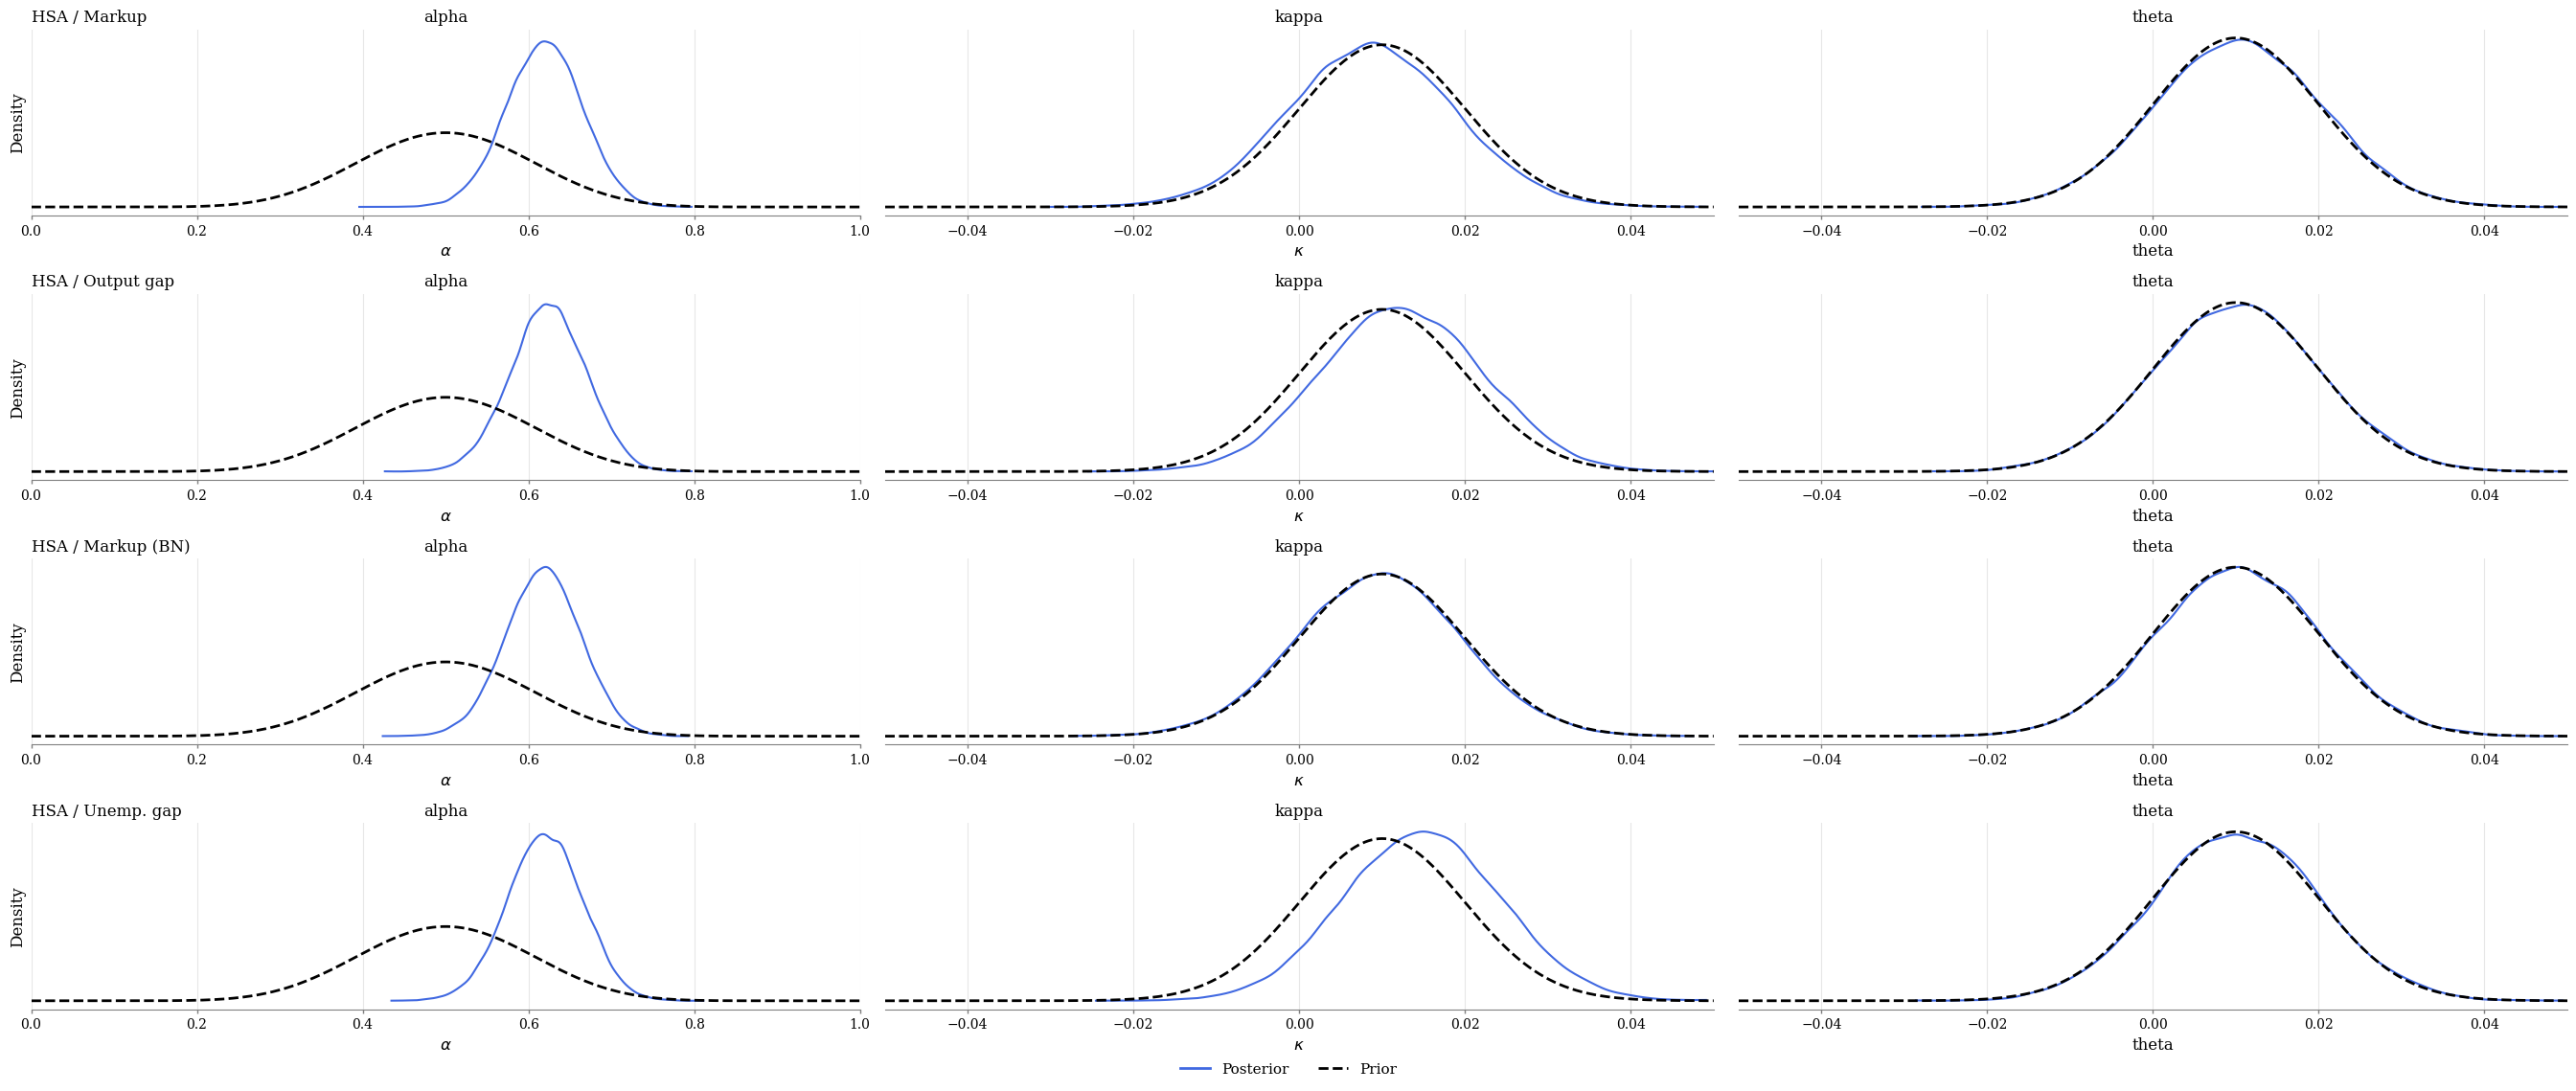

In [ ]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import norm, beta  # add beta

def plot_prior_posterior(idatas, labels, 
                              params=("kappa","alpha"),
                              figsize=(9, 2.8),
                              savepath=None,
                              xlims=None,
                              prior_spec=None):
    """
    Plot posterior (ArviZ) and prior (scipy.stats frozen dists) side by side per parameter.

    idatas     : list of InferenceData (one per row)
    labels     : list of str, row labels
    params     : tuple of parameter names (columns)
    figsize    : (width_per_col, height_per_row)
    savepath   : optional path to save the figure
    xlims      : dict of fixed x-limits, e.g. {"kappa":(-0.05,0.05), "alpha":(0,1)}
    prior_spec : dict of scipy.stats frozen distributions keyed by param name.
                 e.g. {"alpha": beta(12,12), "kappa": norm(0,0.01)}
    """

    assert len(idatas) == len(labels)
    n_rows = len(idatas)
    n_cols = len(params)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(figsize[0]*n_cols, figsize[1]*n_rows),
                             squeeze=False, sharey='col')

    # default priors if none provided:
    if prior_spec is None:
        prior_spec = {
            "alpha": beta(12, 12),   # support [0,1]
            "kappa": norm(0, 0.1),
            "theta": norm(0, 0.1),
        }

    for i, (idata, label_row) in enumerate(zip(idatas, labels)):
        for j, param in enumerate(params):
            ax = axes[i, j]

            # posterior density (KDE) from ArviZ
            az.plot_posterior(
                idata,
                var_names=[param],
                point_estimate=None,
                hdi_prob="hide",
                kind="kde",
                color="royalblue",
                ax=ax,
            )

            # prior density using scipy.stats frozen distribution
            if (prior_spec is not None) and (param in prior_spec):
                dist_frozen = prior_spec[param]

                # choose plotting range: xlims override, else support-aware default
                if xlims and param in xlims:
                    xmin, xmax = xlims[param]
                else:
                    # for Beta, natural support [0,1]; for others, mean±5σ if available
                    if hasattr(dist_frozen, "dist") and getattr(dist_frozen.dist, "name", "") == "beta":
                        xmin, xmax = 0.0, 1.0
                    elif hasattr(dist_frozen, "mean") and hasattr(dist_frozen, "std"):
                        m, s = dist_frozen.mean(), dist_frozen.std()
                        xmin, xmax = m - 5*s, m + 5*s
                    else:
                        # fallback
                        xmin, xmax = -1.0, 1.0

                x = np.linspace(xmin, xmax, 1000)
                # clip to support for beta-like bounded dists
                y = dist_frozen.pdf(x)
                # simple guard against NaNs/inf
                y = np.where(np.isfinite(y), y, 0.0)
                ax.plot(x, y, "k--", lw=2, label="Prior")

            # labels
            if j == 0:
                ax.set_ylabel("Density", fontsize=12)
                ax.set_title(label_row, fontsize=12, loc="left")
            else:
                ax.set_ylabel("")
            ax.set_xlabel({"kappa": r"$\kappa$", "alpha": r"$\alpha$"}.get(param, param),
                          fontsize=12)
            ax.tick_params(labelsize=10)

            # lock x-limits if provided
            if xlims and param in xlims:
                ax.set_xlim(xlims[param])

    # legend
    legend_handles = [
        Line2D([0], [0], color="royalblue", lw=2, label="Posterior"),
        Line2D([0], [0], color="k", lw=2, ls="--", label="Prior"),
    ]
    fig.legend(handles=legend_handles, fontsize=11,
               loc="lower center", ncol=2, frameon=False,
               bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout()

    if savepath:
        fig.savefig(savepath, bbox_inches="tight", dpi=300)

    return fig

idatas_hsa = [
    idata_1_markup,
    idata_1_output,
    idata_1_markup_bn,
    idata_1_unempgap,
]
labels_hsa = [
    "HSA / Markup",
    "HSA / Output gap",
    "HSA / Markup (BN)",
    "HSA / Unemp. gap",
]

fig = plot_prior_posterior(
    idatas=idatas_hsa,
    labels=labels_hsa,
    params=("alpha","kappa","theta"),
    savepath="../figure/hsa_results_hmc.png",
    xlims={"kappa": (-1, 1), "alpha": (0, 1), "theta": (-0.05, 0.05)}  
)
plt.show()

# Estimated results

### coeficients

In [ ]:
import pandas as pd
dict_idata = {
    'CES markup':idata_0_markup,
    'HSA markup': idata_1_markup,
    'CES: output gap': idata_0_output,
    'HSS: output gap': idata_1_output,
    'CES: markup (BN)':idata_0_markup_bn,
    'HSA: markup (BN)': idata_1_markup_bn,
    'CES : unemp gap': idata_0_unempgap,
    'HSA : unemp gap': idata_1_unempgap,
    }

params = [
    "alpha", "kappa", "theta", "rho_1", "rho_2",  "n"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.7f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)
outdir = "../estimated_coef"
fname = f"{outdir}/results_table_hmc.md"
# Markdown 
def df_to_markdown(df):
    header = "| " + " | ".join(df.columns) + " |"
    separator = "| " + " | ".join([":---" for _ in df.columns]) + " |"
    rows = ["| " + " | ".join(map(str, row)) + " |" for row in df.values]
    return "\n".join([header, separator] + rows)

with open(fname, "w") as f:
    f.write(df_to_markdown(summary_df))


,model,alpha,kappa,theta,rho_1,rho_2,n
0,CES markup,0.6190000,0.0090000,-,-,-,-
1,HSA markup,0.6190000,0.0090000,0.0100000,1.7770000,-0.8760000,-0.0140000
2,CES: output gap,0.6240000,0.0120000,-,-,-,-
3,HSS: output gap,0.6240000,0.0120000,0.0100000,1.7760000,-0.8750000,-0.0140000
4,CES: markup (BN),0.6180000,0.0100000,-,-,-,-
5,HSA: markup (BN),0.6180000,0.0100000,0.0100000,1.7770000,-0.8760000,-0.0140000
6,CES : unemp gap,0.6200000,0.0150000,-,-,-,-
7,HSA : unemp gap,0.6190000,0.0150000,0.0100000,1.7780000,-0.8770000,-0.0140000


## Decomposition Check

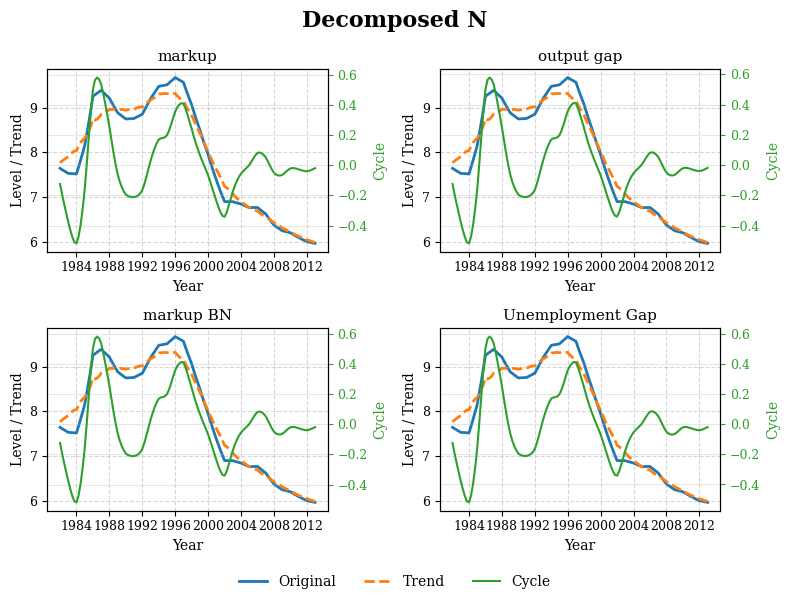

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=False)
fig.suptitle("Decomposed N", fontsize=16, fontweight="bold")

def plot_decomposition_ax(ax, date, original, trend, cycle, title, loc="upper left"):
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # level & trend
    ax.plot(date, original, label="Original", color=colors[0], linewidth=2)
    ax.plot(date, trend,    label="Trend",    color=colors[1], linestyle="--", linewidth=2)
    ax.set_xlabel("Year")
    ax.set_ylabel("Level / Trend")
    ax.set_title(title, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.5)

    # cycle (twin axis)
    ax2 = ax.twinx()
    ax2.plot(date, cycle, label="Cycle", color=colors[2], linewidth=1.5)
    ax2.set_ylabel("Cycle", color=colors[2])
    ax2.tick_params(axis="y", colors=colors[2])

    # return handles for legend
    lines  = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    return lines, labels

handles, labels = plot_decomposition_ax(
    axes[0,0], data["DATE"], data["N"], 
    N_bar_mean_markup, N_hat_mean_markup,
    "markup", loc="lower right"
)
plot_decomposition_ax(
    axes[0,1], data["DATE"], data["N"], 
    N_bar_mean_1_output, N_hat_mean_1_output,
    "output gap", loc="lower right"
)
plot_decomposition_ax(
    axes[1,0], data["DATE"], data["N"], 
    N_bar_mean_1_markup_bn, N_hat_mean_1_markup_bn,
    "markup BN", loc="lower right"
)
plot_decomposition_ax(
    axes[1,1], data["DATE"], data["N"], 
    N_bar_mean_1_unempgap, N_hat_mean_1_unempgap,
    "Unemployment Gap", loc="lower right"
)

# legend
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, fontsize=10)

# layout
plt.tight_layout(rect=[0,0.05,1,1])

# save
outdir = "../figure"
fname = f"{outdir}/decomposition_hmc.png"
plt.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()

# Model Comparison

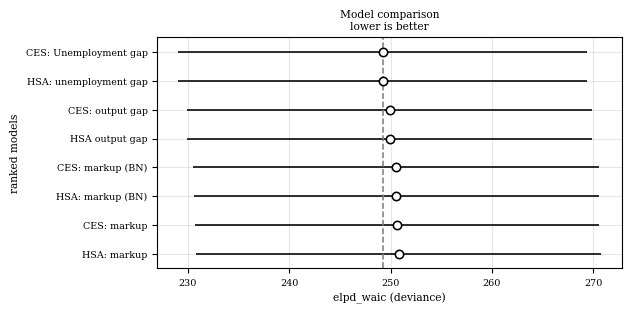

In [ ]:
dict_idata = {
    'CES: markup': idata_0_markup, 'HSA: markup': idata_1_markup, 
    'CES: markup (BN)': idata_0_markup_bn, 'HSA: markup (BN)': idata_1_markup_bn,
    'CES: output gap': idata_1_output, 'HSA output gap': idata_1_output,
    'CES: Unemployment gap': idata_1_unempgap, 'HSA: unemployment gap': idata_1_unempgap
    }
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(6, 3))
fname = f"{outdir}/waic.png"
plt.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()